In [11]:
%cd ..
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # use cpu because I'm training on gpu

# from thumbs.experiments.pokemjon_big_both import PokemonExperiment
from thumbs.experiments.pokemon_pokedex import PokemonExperiment
from thumbs.train import load_weights
from thumbs.viz import show_samples, visualize_preprocessed_image
from thumbs.data import load_and_preprocess_image
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt



/home/anthony/workspace


Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 821 total files
Found 819 jpgs


  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

shapes (819, 128, 128, 3) (819,)


<Figure size 640x480 with 0 Axes>

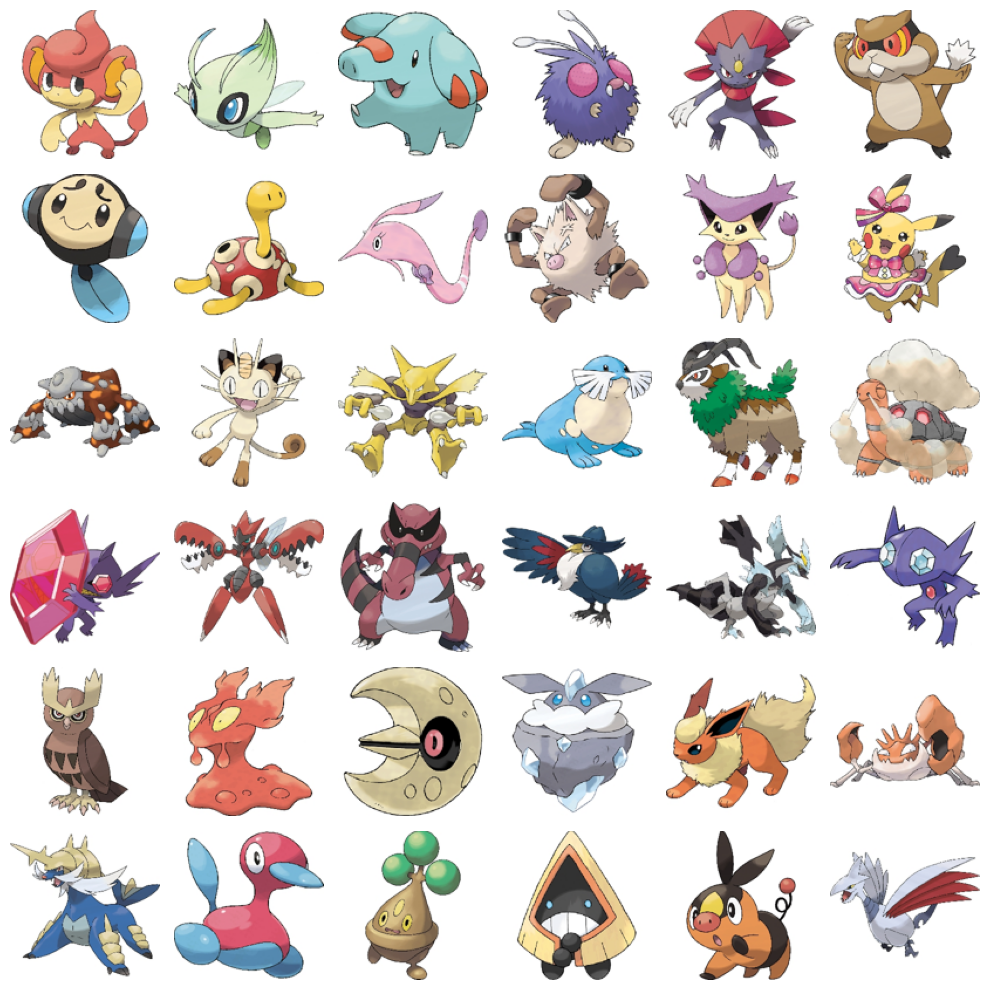

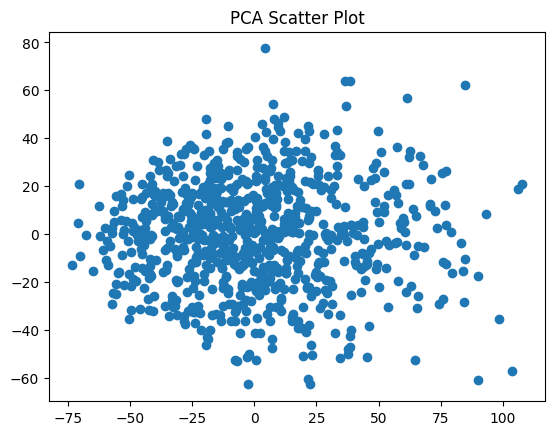

Using 721 as the embedding input size
Model: "discriminator"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                               Output Shape                                                Param #             Connected to                                                
 input_3 (InputLayer)                                       [(None, 1)]                                                 0                   []                                                          
                                                                                                                                                                                                        
 embedding_2 (Embedding)                                    (None, 1, 100)                                              72100          

In [12]:
exp = PokemonExperiment()
mparams = exp.get_mutable_params()
m = exp.get_model(mparams[0]).build()
load_weights(m.generator, exp.get_params().gen_weight_path)
load_weights(m.discriminator, exp.get_params().dis_weight_path)

# Make a fake pokemon and judge it

------------------------------------------------------------
PARAMS
HyperParams(latent_dim=10, name='pkmn-pokedex_10dim_100embded_64x8_128-batch_d2-g1_2-hidden_00005lr', img_shape=(128, 128, 3), generator_clip_gradients_norm=None, base_dir='/mnt/e/experiments', sampler=<Sampler.NORMAL: 1>, similarity_threshold=0, similarity_penalty=10)

MUTABLE PARAMS
MutableHyperParams(iterations=3000, batch_size=128, sample_interval=20, gen_learning_rate=4e-05, dis_learning_rate=5e-05, adam_b1=0.5, generator_turns=1, discriminator_turns=2, checkpoint_interval=200, discriminator_training=True, generator_training=True, gradient_penalty_factor=10.0, l1_loss_factor=None, l2_loss_factor=None, discriminator_ones_zeroes_shape=(128, 1), g_clipnorm=None, d_clipnorm=None, dis_weight_decay=0, gen_weight_decay=0, adam_b2=0.999, discriminator_turns_mode=<TurnMode.SAME_SAMPLES: 1>, generator_turns_mode=<TurnMode.SAME_SAMPLES: 1>)

Restored losses: 589
Restored iterations: 589
--------------------------------------

<Figure size 640x480 with 0 Axes>

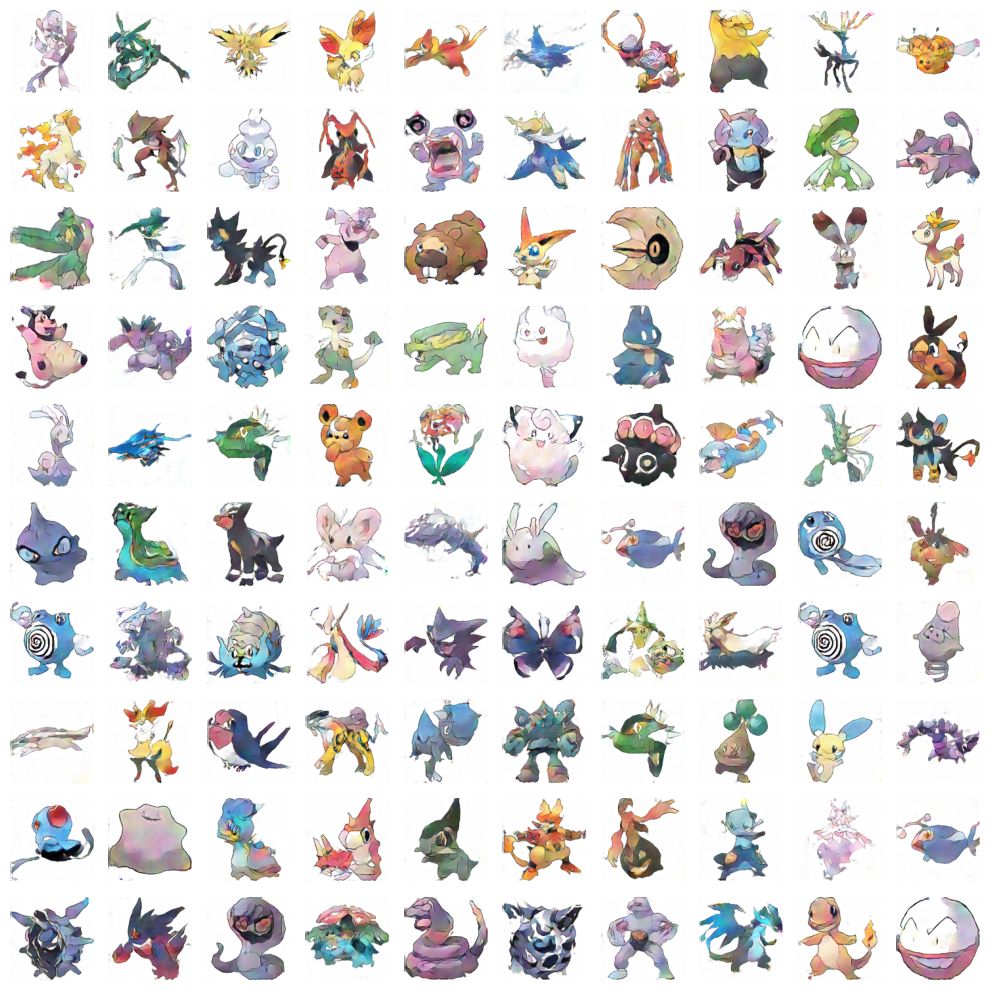

In [13]:
# show_samples(m.generator, exp.get_params().latent_dim, rows=10, cols=10, label_getter=exp.get_random_labels)

train = exp.get_train(m, exp.get_mutable_params()[0])
train.show_samples(rows=10, cols=10, file_name=None)


### View some pokemon with mega forms

Sometimes the model has trouble learning how to generate pokemon with mega forms. The noise should determine what form the prediction takes. If you can't get both forms of Glalie then the model may be underpowered.

<Figure size 640x480 with 0 Axes>

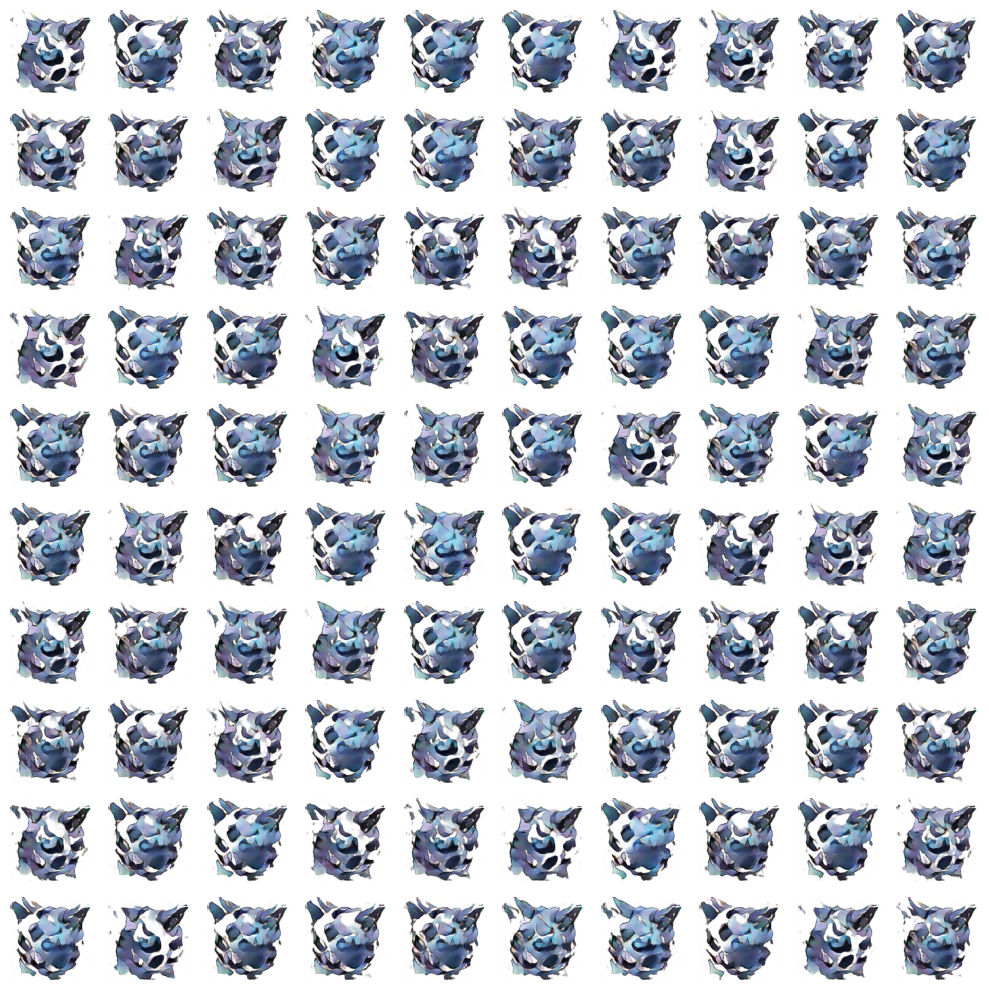

In [15]:
charizard = np.expand_dims(np.array(6), axis=0) 
glalie = np.expand_dims(np.array(362), axis=0) 

def get_labels(n):
    return (np.array([362] * n),)

# Show a bunch of charizards because the noise actually matters there, there are two mega forms in the dataset
show_samples(m.generator, exp.params.latent_dim, label_getter=get_labels, file_name=None, dir=None, rows=10, cols=10)

# Make a model that takes embeddings in

This lets us interpolate between different embeddings to see if the model learned smoothly

In [5]:
emodel = exp.get_model(mparams[0]).build_generator_embedding_input(exp.get_params().latent_dim)
emodel.summary()

Using 721 as the embedding input size
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 pokedex_number_embedding (  [(None, 100)]                0         []                            
 InputLayer)                                                                                      
                                                                                                  
 z (InputLayer)              [(None, 10)]                 0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 100)                  0         ['pokedex_number_embedding[0][
                                                                    0]']                          
                                                    

In [6]:
# Load every weight from m.generator by layer name
for layer in emodel.layers:
    # print(f'Setting weights for layer {layer.name}')
    try:
        layer.set_weights(m.generator.get_layer(layer.name).get_weights())
        print(f'Successfully set weights for layer {layer.name}')
    except Exception as e:
        # print(f'Failed to set weights for layer {layer.name}: {e}')
        pass


Successfully set weights for layer z
Successfully set weights for layer tconf8.0
Successfully set weights for layer norm8.0
Successfully set weights for layer relu8.0
Successfully set weights for layer tconf5.666666666666666
Successfully set weights for layer norm5.666666666666666
Successfully set weights for layer relu5.666666666666666
Successfully set weights for layer tconf5.666666666666666_0
Successfully set weights for layer norm5.666666666666666_0
Successfully set weights for layer relu5.666666666666666_0
Successfully set weights for layer tconf5.666666666666666_1
Successfully set weights for layer norm5.666666666666666_1
Successfully set weights for layer relu5.666666666666666_1
Successfully set weights for layer tconf3.333333333333333
Successfully set weights for layer norm3.333333333333333
Successfully set weights for layer relu3.333333333333333
Successfully set weights for layer tconf3.333333333333333_0
Successfully set weights for layer norm3.333333333333333_0
Successfully s

In [7]:
# Get the embedding layer from the trained model
# Its going to be 1 off from the actual index, so we need to subtract 1
e = m.generator.get_layer("embedding_1")
e(5) # charizard

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-0.01733798,  0.04290221,  0.03499292, -0.00877856, -0.01726442,
        0.05148917,  0.00674235,  0.00371632, -0.05377115, -0.0349312 ,
       -0.03627567, -0.02519686,  0.03075968,  0.04433905, -0.04228932,
       -0.01240228,  0.01413552, -0.03973629, -0.03883796, -0.03041454,
        0.05711377, -0.04756207,  0.03231072, -0.02012147, -0.01190349,
       -0.04666117,  0.00941429,  0.02061285,  0.03402613, -0.00440473,
       -0.01633988, -0.03438485,  0.0128538 ,  0.00029619, -0.05126121,
       -0.03639832,  0.02178346,  0.03309812,  0.02914164, -0.05539202,
       -0.01434765,  0.00371319,  0.03528408, -0.00933565,  0.01791046,
        0.00319296, -0.03435047, -0.0200601 , -0.01407292, -0.04077905,
        0.02028594,  0.03095754, -0.02874252,  0.01869261,  0.03513134,
        0.02636953, -0.0239491 ,  0.00833878,  0.0438826 , -0.02017698,
       -0.01555077,  0.04273618,  0.02749865,  0.01309752, -0.01386198,
        0.050300

### Embedding arithmatic

1/1 [==============================] - 0s 50ms/step


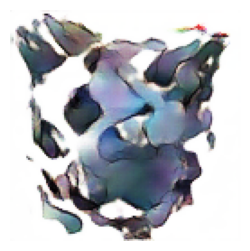

1/1 [==============================] - 0s 64ms/step


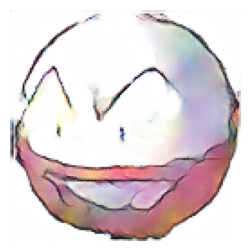

1/1 [==============================] - 0s 51ms/step


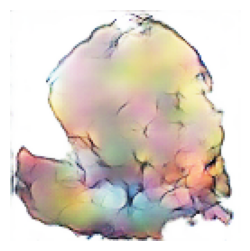

In [19]:
blastoise = e(8)
charizard = e(5)
pikachu = e(24)
staryu = e(119)
charmander = e(3)
growlithe = e(57)
electrode = e(100)
diglett = e(49)
glalie = e(361)

noise = np.random.normal(0, 1, (1, exp.params.latent_dim))
generated_thumbnails = emodel.predict([noise, np.expand_dims(glalie, axis=0)])
visualize_preprocessed_image(generated_thumbnails[0], (3,3))

generated_thumbnails = emodel.predict([noise, np.expand_dims(electrode, axis=0)])
visualize_preprocessed_image(generated_thumbnails[0], (3,3))

generated_thumbnails = emodel.predict([noise, np.expand_dims(electrode + diglett - pikachu, axis=0)])
visualize_preprocessed_image(generated_thumbnails[0], (3,3))

In [25]:
from thumbs.util import unnormalize_image

def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 4))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off') # Hide axes
    plt.show()

# Interpolate between both noises 
def interpolate_vectors(A, B, num_interpolations=8):
    alphas = np.linspace(0, 1, num_interpolations)
    return np.array([(1 - alpha) * A + alpha * B for alpha in alphas])

def interpolated_pokemon(a, b):
    noise = np.random.normal(0, 1, (1, exp.params.latent_dim))
    imgs = []
    for dex in interpolate_vectors(a, b, 10):
        dex = np.expand_dims(dex, axis=0)
        generated_thumbnails = emodel.predict([ noise, dex ], verbose=0)
        imgs.append(unnormalize_image(generated_thumbnails[0]))
    
    return imgs


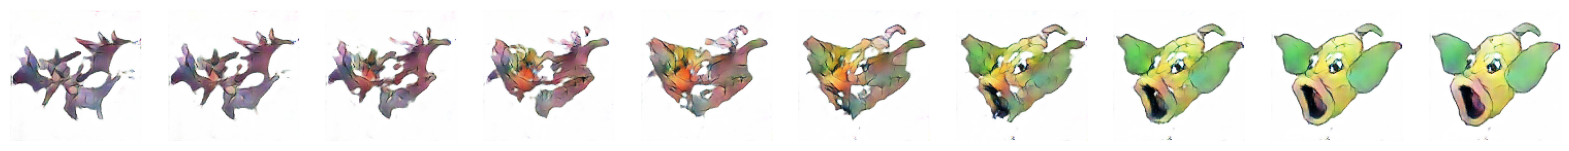

In [40]:

random1 = e(np.random.randint(0, 720))
random2 = e(np.random.randint(0, 720))
plot_images(interpolated_pokemon(random1, random2))

In [12]:
# mean of a lot of generated images
noise = np.random.normal(0, 1, (800, exp.get_params().latent_dim))
generated_thumbnails = m.generator.predict(noise)
print(np.mean(m.discriminator.predict(generated_thumbnails)))

25/25 [==============================] - 2s 81ms/step
-88.1726


# Determine attribution

In [21]:

# Define a function to compute the attribution maps using Gradient*Input method
def compute_attribution_map(image: np.ndarray):
    image = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image)
        output = m.discriminator(image)
    
    gradients = tape.gradient(output, image)
    attribution_map = gradients * image
    
    return attribution_map

def show_attribution(input_image):
    preprocessed_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Compute the attribution map for the input image
    attribution_map = compute_attribution_map(preprocessed_image)
    # Convert the attribution map to a grayscale image
    attribution_map = np.mean(attribution_map, axis=-1, keepdims=True)

    # Normalize the attribution map to [0, 1]
    attribution_map -= np.min(attribution_map)
    attribution_map /= np.max(attribution_map)

    # Resize the attribution map to the original image size for visualization
    attribution_map = tf.image.resize(attribution_map, size=(128, 128)).numpy()


    # Convert them back to 0,255. The pokemon images look better that way, just keep
    # the attribution map consistent
    input_image = ((input_image + 1) * 127.5).astype(np.uint8)


    # Display the original image and the attribution map
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(input_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(attribution_map.squeeze(axis=0), cmap='bwr')
    axes[1].set_title('Attribution Map')
    axes[1].axis('off')
    plt.show()


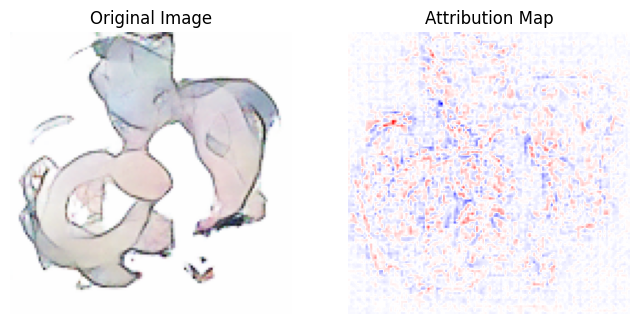

In [22]:

show_attribution(generated_thumbnails[0])

### Sanity check against an absurd image

1/1 [==============================] - 0s 24ms/step
[[-31.376331]]


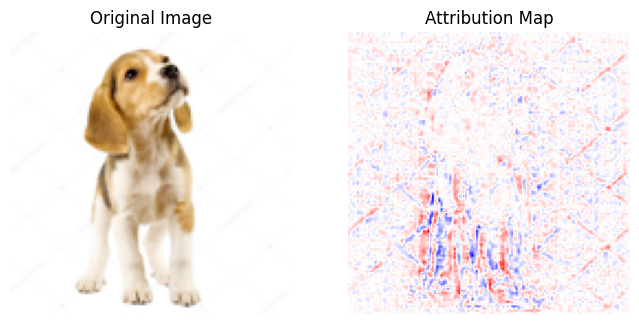

In [23]:
# load 
egg_jpg = '/home/anthony/windows/Downloads/dog_white.jpg'
egg = load_and_preprocess_image(egg_jpg, (128, 128, 3))

print(m.discriminator.predict(np.expand_dims(egg, axis=0)))
show_attribution(egg)

# Judge a real pokemon

Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 821 total files
Found 819 jpgs


  0%|          | 0/819 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

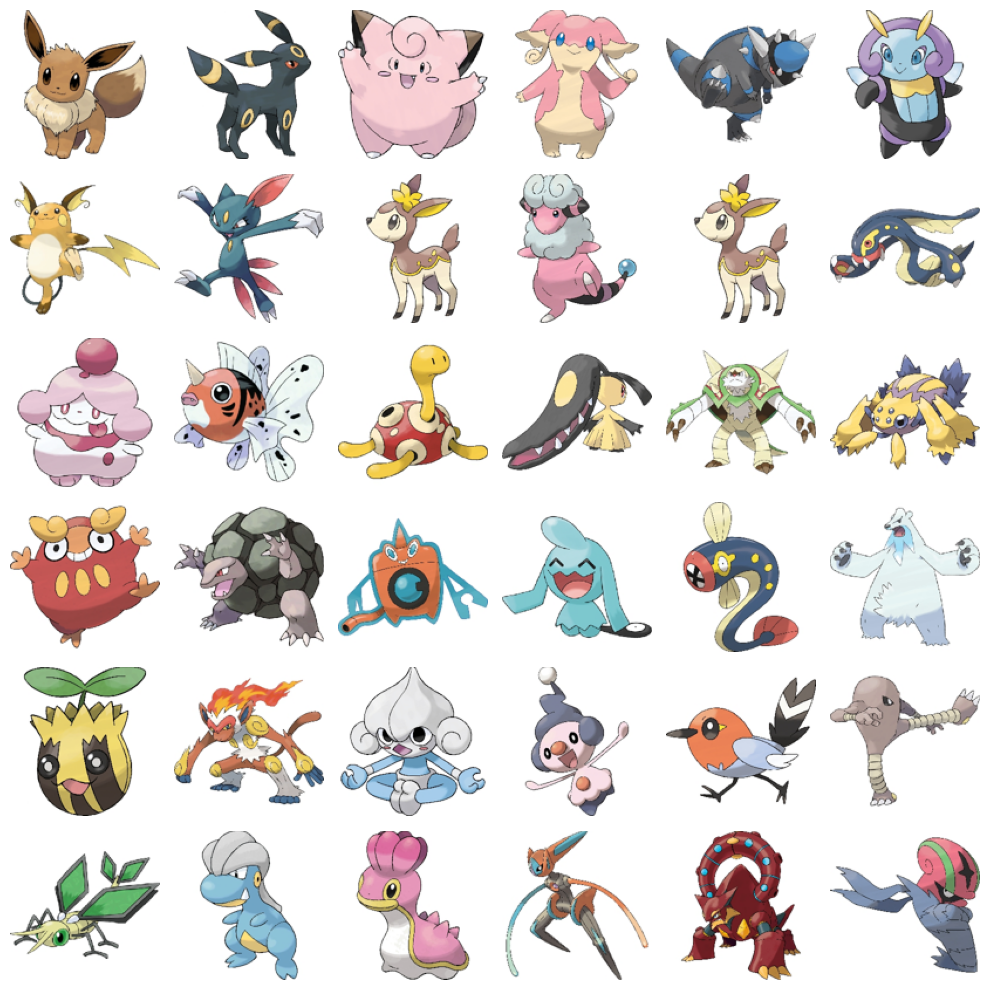

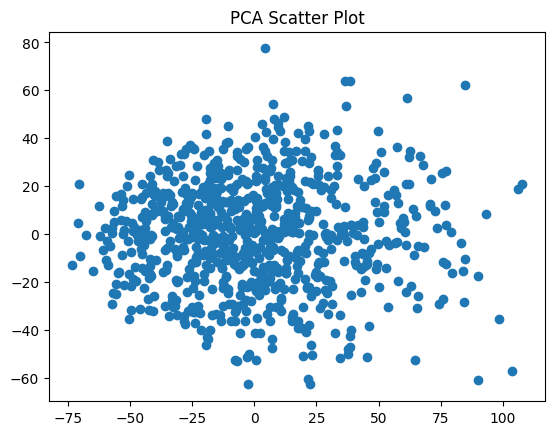

(819, 128, 128, 3)

In [4]:
from thumbs.data import get_pokemon_data256
images = get_pokemon_data256(exp.get_params().img_shape)
images.shape

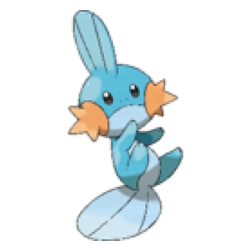

1/1 [==============================] - 0s 26ms/step
[[-29.83461]]


In [10]:
real_pokemon = images[np.random.randint(0, images.shape[0], 1)]
visualize_preprocessed_image(real_pokemon[0], (3,3))

print(m.discriminator.predict(real_pokemon))



In [11]:
# Get the average of all real pokemon
m.discriminator.predict(images).mean()

26/26 [==============================] - 2s 90ms/step


-19.088385

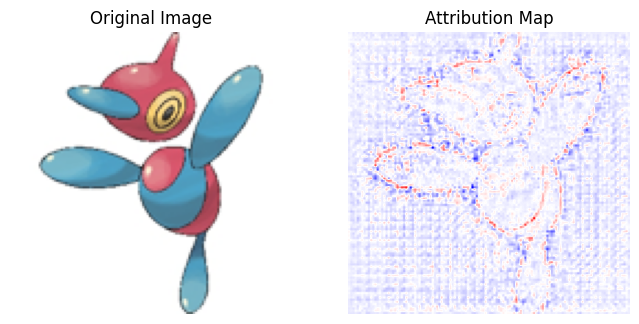

In [26]:

show_attribution(real_pokemon[0])

In [27]:

# Mean of the entire real set
print(np.mean(m.discriminator.predict(images)))

26/26 [==============================] - 2s 91ms/step
-20.022121


# Get FID score

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

2023-08-11 16:16:06.881042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=exp.get_params().img_shape)

In [10]:
real_images = exp.data[0]
total = real_images.shape[0] * 2
fake_images = m.generator.predict((exp.params.latent_sample(total), *exp.get_random_labels(total)))
fid = calculate_fid(inception_model, real_images, fake_images)
fid

52/52 [==============================] - 6s 106ms/step


903.8595616457848

# Inspect Generator hidden layer output

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def get_intermediate_models(model):
    intermediate_models = []
    # layers_to_get = [2,5,8,11, 12]
    for i in range(len(model.layers)):
        # only pick models that have conv2d_transpose_1 or tanh in the name
        layer = model.layers[i]
        if 'conv2d' in layer.output.name.lower() or 'tanh' in layer.output.name.lower() or len(layer.output.shape) == 4:
            print(model.layers[i])
            intermediate_model = Model(inputs=model.input, outputs=model.layers[i].output)
            intermediate_models.append(intermediate_model)
    return intermediate_models


def inspect_layers(model, input):
    intermediate_models = get_intermediate_models(model)
    for i, intermediate_model in enumerate(intermediate_models):
        print(f'Layer {i+1} of {len(intermediate_models)}, shape {intermediate_model.output_shape}, name {intermediate_model.output.name}')
        intermediate_output = intermediate_model.predict(input, verbose=0)

        intermediate_output = intermediate_output[0]
        # n = 64
        # intermediate_output = intermediate_output[:, :, :n]

        intermediate_output -= intermediate_output.min() # Make the minimum 0
        intermediate_output /= intermediate_output.max() # Make the maximum 1

        n_cols = 4
        n_channels = min(n_cols, intermediate_output.shape[2])
        fig, axs = plt.subplots(n_channels , n_cols, figsize=(8, 8))
        for i in range(n_channels):
            for j in range(n_cols):
                if n_channels == 3:
                    axs[i][j].imshow(intermediate_output)
                else:
                    axs[i][j].imshow(intermediate_output[:, :, np.random.randint(0, intermediate_output.shape[2])])
                axs[i][j].axis('off')

        plt.show()



Layer 1 of 14, shape (None, 1, 1, 60), name reshape_1/Reshape:0


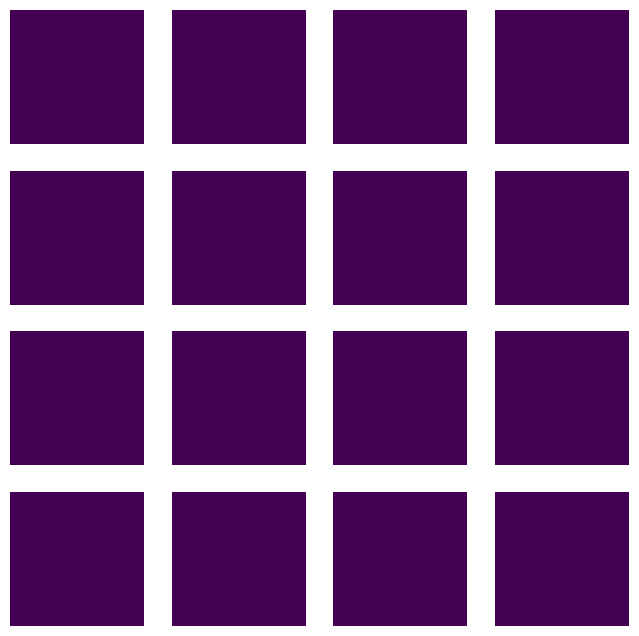

Layer 2 of 14, shape (None, 8, 8, 512), name conv2d_transpose_5/conv2d_transpose:0


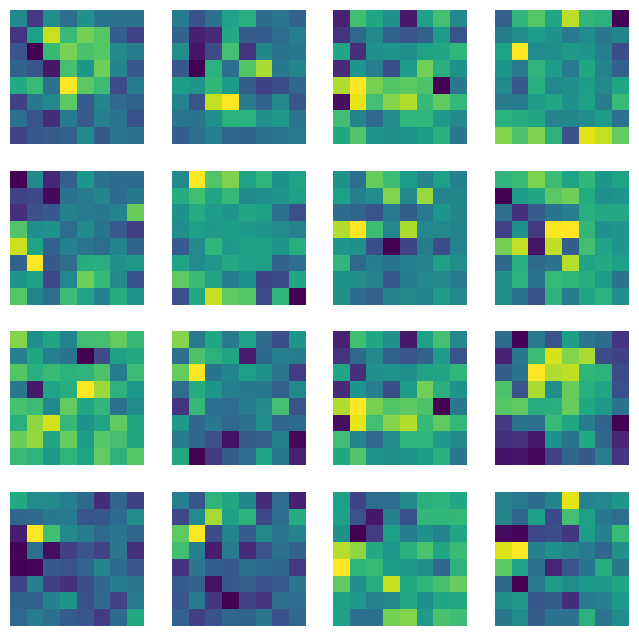

Layer 3 of 14, shape (None, 8, 8, 512), name layer_normalization_10/add:0


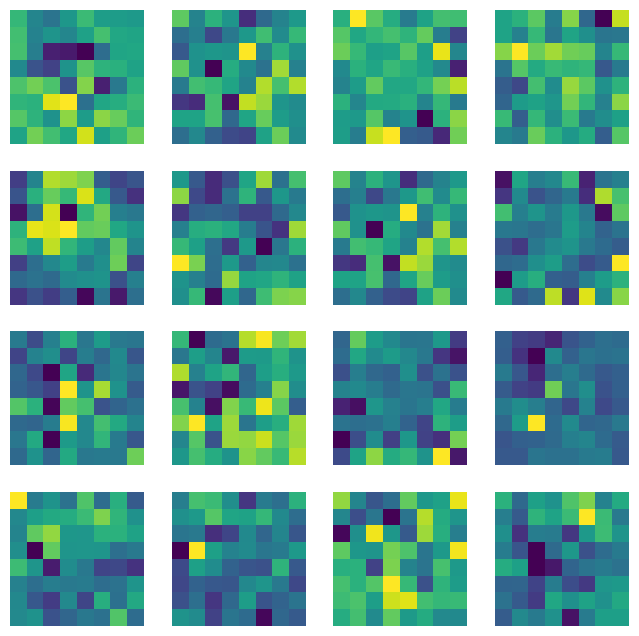

Layer 4 of 14, shape (None, 8, 8, 512), name leaky_re_lu_12/LeakyRelu:0


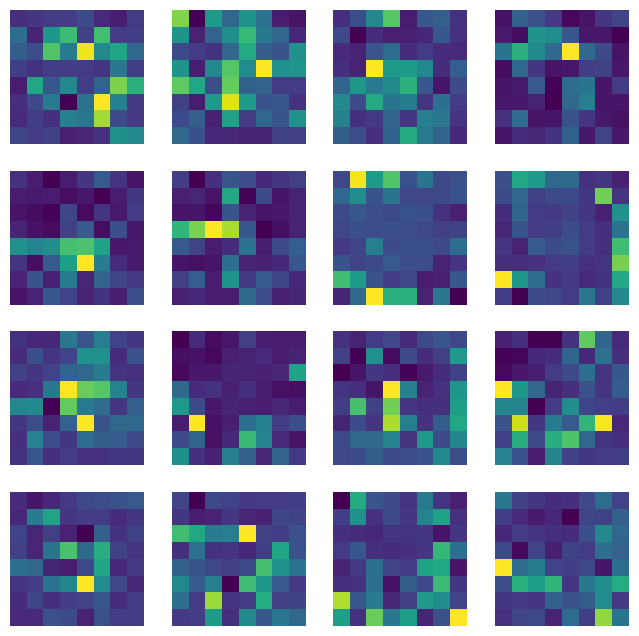

Layer 5 of 14, shape (None, 16, 16, 320), name conv2d_transpose_6/conv2d_transpose:0


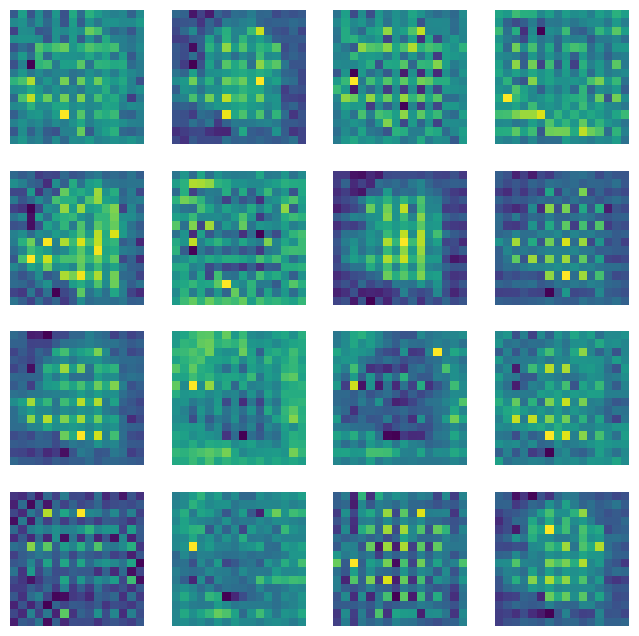

Layer 6 of 14, shape (None, 16, 16, 320), name layer_normalization_11/add:0


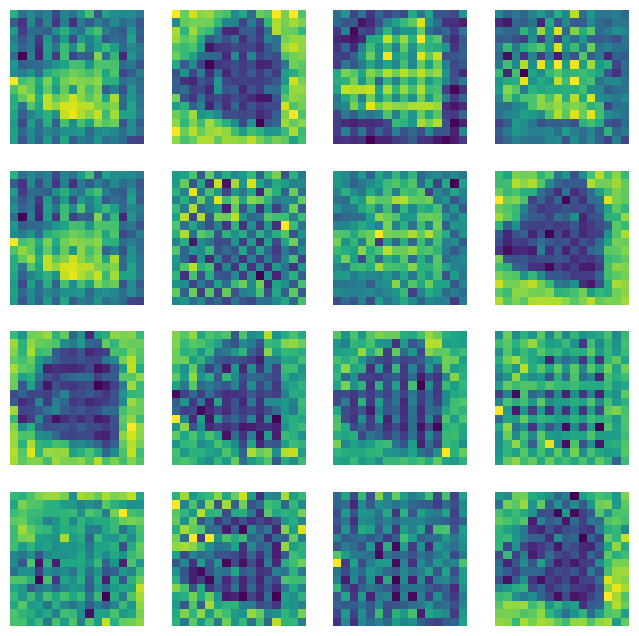

Layer 7 of 14, shape (None, 16, 16, 320), name leaky_re_lu_13/LeakyRelu:0


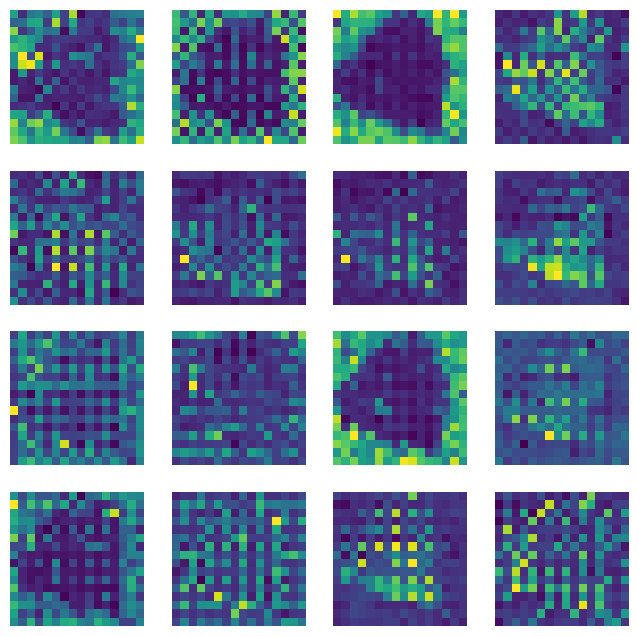

Layer 8 of 14, shape (None, 32, 32, 192), name conv2d_transpose_7/conv2d_transpose:0


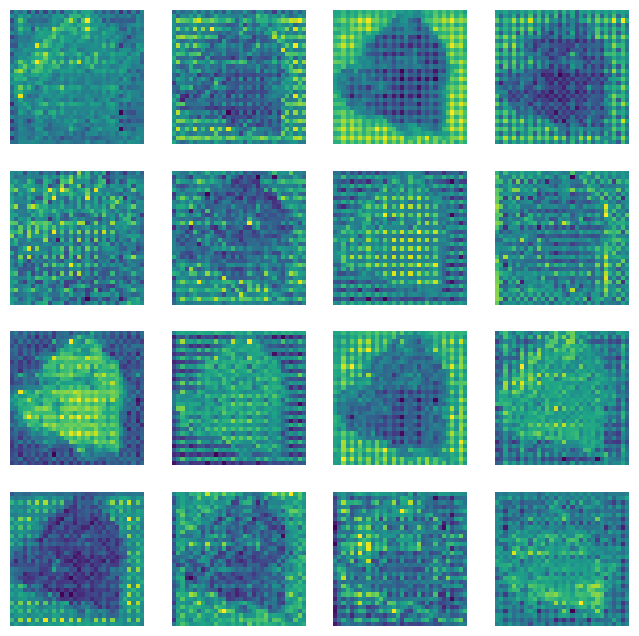

Layer 9 of 14, shape (None, 32, 32, 192), name layer_normalization_12/add:0


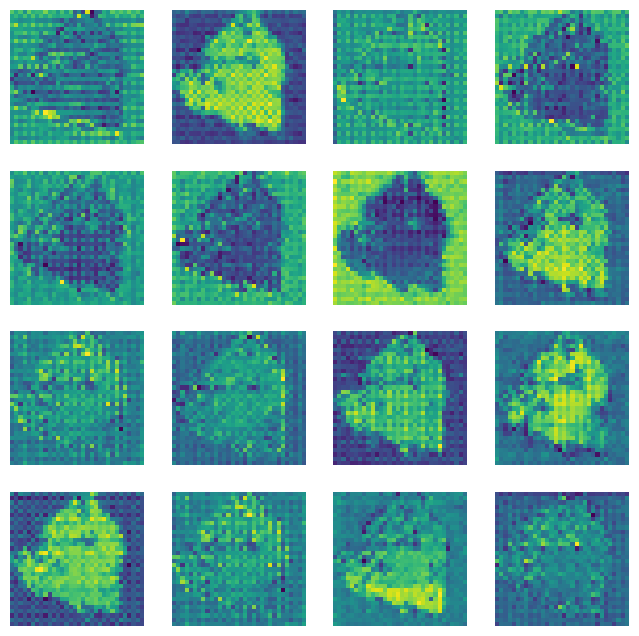

Layer 10 of 14, shape (None, 32, 32, 192), name leaky_re_lu_14/LeakyRelu:0


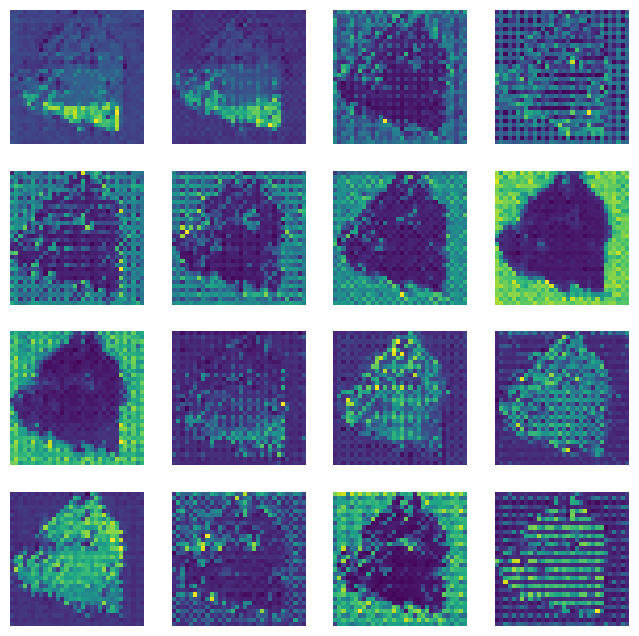

Layer 11 of 14, shape (None, 64, 64, 64), name conv2d_transpose_8/conv2d_transpose:0


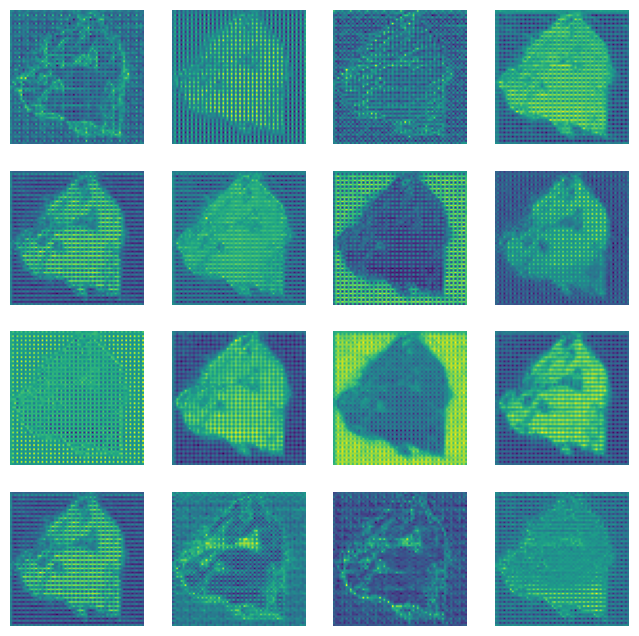

Layer 12 of 14, shape (None, 64, 64, 64), name layer_normalization_13/add:0


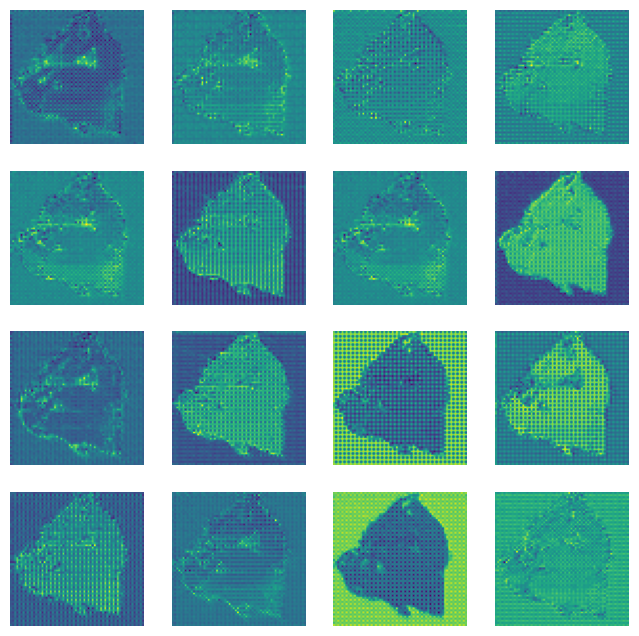

Layer 13 of 14, shape (None, 64, 64, 64), name leaky_re_lu_15/LeakyRelu:0


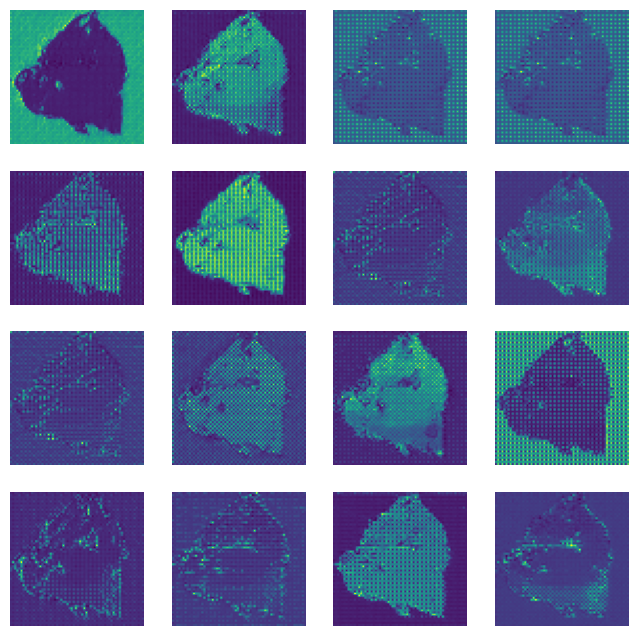

Layer 14 of 14, shape (None, 128, 128, 3), name conv2d_transpose_9/Tanh:0


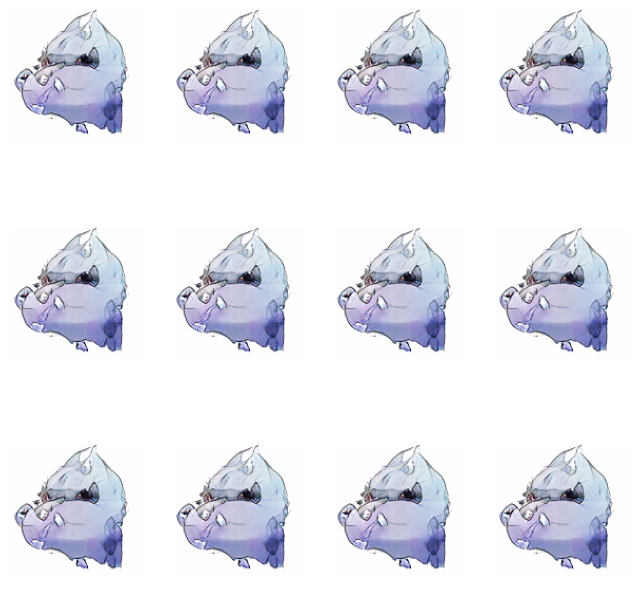

In [32]:

noise = np.random.normal(0, 1, (1, exp.params.latent_dim))
inspect_layers(m.generator, noise)

 # Inspect Discriminator hidden layers

In [33]:
noise = np.random.normal(0, 1, (1, 100))
generated_image = m.generator.predict(noise)
visualize_preprocessed_image(generated_image[0], (3,3))

inspect_layers(m.discriminator, generated_image)


InvalidArgumentError: Graph execution error:

Detected at node 'generator/reshape_1/Reshape' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2082/3911206034.py", line 2, in <module>
      generated_image = m.generator.predict(noise)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/keras/src/layers/reshaping/reshape.py", line 137, in call
      result = tf.reshape(inputs, (tf.shape(inputs)[0],) + self.target_shape)
Node: 'generator/reshape_1/Reshape'
Input to reshape is a tensor with 100 values, but the requested shape has 60
	 [[{{node generator/reshape_1/Reshape}}]] [Op:__inference_predict_function_56813]